In [1]:
import geopandas as gpd
from geopandas import GeoSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon, box
from shapely.geometry import LineString, shape
from shapely.prepared import prep
import random
import shapely
import osmnx as ox
import networkx as nx
import copy
import importlib
import utils
# from get_data import local_==

/Users/jinming/miniforge3/envs/torch/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Determin coordinate system

In [2]:
NAD83 = {'init': 'EPSG:6443'} # West Florida (for calculation and analysis)
LatLong = {'init': 'EPSG:4269'} # North America (for openstreetmap API)

## Load Area of Analysis

(1,)


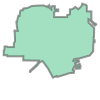

In [3]:
directory = './data/'
path_blockGEOs = directory + 'Aoa_geo_new/'
AoA_geo = gpd.read_file(path_blockGEOs)['geometry']
print(AoA_geo.shape)
AoA_geo[0]

In [4]:
AoA_geo = AoA_geo.to_crs(NAD83)
centroid_xy = [AoA_geo.centroid.x[0], AoA_geo.centroid.y[0]]
centroid_xy

[509200.6345122302, 1314107.5183594998]

In [5]:
AoA_geo.area

0    4.265212e+07
dtype: float64

## Load Tampa Block Data

In [6]:
df_tampa_blocks = gpd.read_file(directory + 'tampa_blocks/')
df_tampa_blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,population,geometry
0,12,057,005302,1006,120570053021006,Block 1006,G5040,U,86599,U,S,2928,0,+27.9552775,-082.4449098,0.0,"POLYGON ((512328.448 1316694.783, 512355.920 1..."
1,12,057,005101,1199,120570051011199,Block 1199,G5040,U,86599,U,S,1165,0,+27.9431327,-082.4582061,0.0,"POLYGON ((508145.621 1312337.987, 508311.303 1..."
2,12,057,005101,1205,120570051011205,Block 1205,G5040,U,86599,U,S,21961,0,+27.9426526,-082.4568782,0.0,"POLYGON ((508311.658 1312273.741, 508663.350 1..."
3,12,057,005101,1143,120570051011143,Block 1143,G5040,U,86599,U,S,1588,0,+27.9468790,-082.4515359,0.0,"POLYGON ((510359.265 1313663.313, 510407.639 1..."
4,12,057,005101,1191,120570051011191,Block 1191,G5040,U,86599,U,S,3874,0,+27.9442611,-082.4547921,0.0,"POLYGON ((509120.333 1312676.461, 509673.559 1..."


## Load Downtowner Data

In [7]:
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
full_dt_data = pd.read_csv(directory + 'tampa_data_sample.csv')
full_dt_data.head()

,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,passengers,combo_id,vehicle_type,vehicle_max_pax
0,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,-82.4526,1,NaN,Ford Transit [ADA],6.0
1,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,-82.4629,1,NaN,Chevrolet Bolt,4.0
2,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,-82.4556,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0
3,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,-82.4544,1,NaN,Chevrolet Bolt,4.0
4,91efe7d0dc054f6542ee8e81c12cf39271f8ff27,660588e7addd32e5391a71106b285240588c50dd,2019-11-01,5,07:11,07:15,27.9535,-82.4609,27.9476,-82.4572,1,6e32c26d7e321d14c6d9bc33cc86ad4965cc9d30,Chevrolet Bolt,4.0


### Extract trip datetime

In [9]:
import datetime

date_list = full_dt_data.date.to_list()
pick_up_time_list = full_dt_data.pickup_time.to_list()
wait_time_list = full_dt_data.wait_time_minutes.to_list()

date_time_list = [date_list[i] + ' ' + pick_up_time_list[i] for i in range(len(date_list))]
date_time_list[:5]

['2019-11-01 07:10',
 '2019-11-01 07:02',
 '2019-11-01 07:07',
 '2019-11-01 07:08',
 '2019-11-01 07:11']

In [10]:
timestr = '2016-10-20 18:16'
dtt = datetime.datetime.strptime(timestr, '%Y-%m-%d %H:%M') - datetime.timedelta(minutes = 23)
print(dtt)

2016-10-20 17:53:00


In [11]:
date_time_list = [datetime.datetime.strptime(date_time_list[i], '%Y-%m-%d %H:%M') - datetime.timedelta(minutes = wait_time_list[i]) for i in range(len(date_list))]

In [12]:
full_dt_data['date_time'] = date_time_list

In [13]:
full_dt_data.head()

,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,passengers,combo_id,vehicle_type,vehicle_max_pax,date_time
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,-82.4526,1,NaN,Ford Transit [ADA],6.0,2019-11-01 07:00:00
1,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,-82.4629,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00
2,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,-82.4556,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0,2019-11-01 07:00:00
3,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,-82.4544,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00
4,369708,91efe7d0dc054f6542ee8e81c12cf39271f8ff27,660588e7addd32e5391a71106b285240588c50dd,2019-11-01,5,07:11,07:15,27.9535,-82.4609,27.9476,-82.4572,1,6e32c26d7e321d14c6d9bc33cc86ad4965cc9d30,Chevrolet Bolt,4.0,2019-11-01 07:06:00


## Sort data by trip starting time

In [14]:
full_dt_data = full_dt_data.sort_values(by='date_time', ascending=True)

In [15]:
full_dt_data.head()

,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,passengers,combo_id,vehicle_type,vehicle_max_pax,date_time
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,-82.4526,1,NaN,Ford Transit [ADA],6.0,2019-11-01 07:00:00
2,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,-82.4556,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0,2019-11-01 07:00:00
5,369709,2856b920792cca226721cce6470f2f6111816fae,60ccbf5aadc3c796ded05d5a7a69e14f93858a16,2019-11-01,12,07:12,07:20,27.9563,-82.4602,27.9453,-82.4581,1,8c6991ff8fd9d96d22393b1cda58788a3467178c,Chevrolet Bolt,4.0,2019-11-01 07:00:00
1,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,-82.4629,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00
3,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,-82.4544,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00


## Datetime to second

In [16]:
def HM2S(time_str):
    return int(time_str[-8:-6]) * 3600 + int(time_str[-5:-3]) * 60 + int(time_str[-2:])

In [17]:
full_dt_data['start_time_sec'] = [HM2S(s) for s in full_dt_data['date_time'].astype(str)]

## Calculate Road time (waiting time excluded)

In [18]:
def travel_time_cal(pickup_time, dropoff_time):
#     Calculate travel time by pickup and dropoff time
#     pickup_time: 'hh:mm'
#     dropoff_time: 'hh:mm'
    h_pickup = int(pickup_time[:2])
    h_dropoff = int(dropoff_time[:2])
    m_pickup = int(pickup_time[-2:])
    m_dropoff = int(dropoff_time[-2:])
    if h_pickup > h_dropoff: # travel cross two days
        h_dropoff += 24
    return (m_dropoff - m_pickup) + (h_dropoff - h_pickup) * 60        

In [19]:
pickup_time = '13:58'
dropoff_time = '14:06'
travel_time_cal(pickup_time, dropoff_time)

8

In [20]:
pickup_time_list = full_dt_data.pickup_time.to_list()
dropoff_time_list = full_dt_data.dropoff_time.to_list()

road_time_list = [travel_time_cal(pickup_time_list[i], dropoff_time_list[i]) for i in range(len(pickup_time_list))]

In [21]:
full_dt_data['road_time'] = road_time_list

In [22]:
full_dt_data.head()

,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,passengers,combo_id,vehicle_type,vehicle_max_pax,date_time,start_time_sec,road_time
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,-82.4526,1,NaN,Ford Transit [ADA],6.0,2019-11-01 07:00:00,25200,4
2,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,-82.4556,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,3
5,369709,2856b920792cca226721cce6470f2f6111816fae,60ccbf5aadc3c796ded05d5a7a69e14f93858a16,2019-11-01,12,07:12,07:20,27.9563,-82.4602,27.9453,-82.4581,1,8c6991ff8fd9d96d22393b1cda58788a3467178c,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,8
1,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,-82.4629,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,8
3,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,-82.4544,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,3


In [23]:
len(full_dt_data)

10082

# Extract Origins and Destinations

In [24]:
def travel_time_cal(pickup_time, dropoff_time):
#     Calculate travel time by pickup and dropoff time
#     pickup_time: 'hh:mm'
#     dropoff_time: 'hh:mm'
    h_pickup = int(pickup_time[:2])
    h_dropoff = int(dropoff_time[:2])
    m_pickup = int(pickup_time[-2:])
    m_dropoff = int(dropoff_time[-2:])
    if h_pickup > h_dropoff: # travel cross two days
        h_dropoff += 24
    return (m_dropoff - m_pickup) + (h_dropoff - h_pickup) * 60

In [25]:
import shapely

travel_time_list = []

passenger_number_list = full_dt_data.passengers.to_list()

pickup_time_list = full_dt_data.pickup_time.to_list()
dropoff_time_list = full_dt_data.dropoff_time.to_list()

origin_lat_list = full_dt_data.pickup_lat.to_list()
origin_lon_list = full_dt_data.pickup_lon.to_list()

destination_lat_list = full_dt_data.dropoff_lat.to_list()
destination_lon_list = full_dt_data.dropoff_lon.to_list()

od_geo_list = []
origin_geo_list = []
destination_geo_list = []

for i in range(len(full_dt_data)):
    origin_geo = shapely.geometry.Point(origin_lon_list[i], origin_lat_list[i])
    destination_geo = shapely.geometry.Point(destination_lon_list[i], destination_lat_list[i])
    origin_geo_list.append(origin_geo)
    destination_geo_list.append(destination_geo)
    od_geo_list.append(shapely.geometry.LineString([origin_geo, destination_geo]))

df_ods = gpd.GeoDataFrame({'geometry': od_geo_list}, crs = LatLong)
df_origins = gpd.GeoDataFrame({'geometry': origin_geo_list}, crs = LatLong)
df_destinations = gpd.GeoDataFrame({'geometry': destination_geo_list}, crs = LatLong)

df_ods = df_ods.to_crs(NAD83)
df_origins = df_origins.to_crs(NAD83)
df_destinations = df_destinations.to_crs(NAD83)

del pickup_time_list, dropoff_time_list, origin_lat_list, origin_lon_list, destination_lat_list, destination_lon_list, od_geo_list, origin_geo_list, destination_geo_list

In [26]:
df_origins.head()

,geometry
0,POINT (505942.920 1313248.683)
1,POINT (510140.739 1313414.714)
2,POINT (507604.002 1317096.217)
3,POINT (511403.743 1314464.406)
4,POINT (507649.141 1311933.383)


In [27]:
df_destinations.head()

,geometry
0,POINT (510046.843 1314214.910)
1,POINT (509077.618 1314036.726)
2,POINT (508266.949 1313094.480)
3,POINT (506737.330 1318408.336)
4,POINT (509455.986 1311599.417)


In [28]:
len(df_origins)

10082

In [29]:
full_dt_data.head()

,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,passengers,combo_id,vehicle_type,vehicle_max_pax,date_time,start_time_sec,road_time
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,-82.4526,1,NaN,Ford Transit [ADA],6.0,2019-11-01 07:00:00,25200,4
2,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,-82.4556,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,3
5,369709,2856b920792cca226721cce6470f2f6111816fae,60ccbf5aadc3c796ded05d5a7a69e14f93858a16,2019-11-01,12,07:12,07:20,27.9563,-82.4602,27.9453,-82.4581,1,8c6991ff8fd9d96d22393b1cda58788a3467178c,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,8
1,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,-82.4629,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,8
3,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,-82.4544,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,3


## Download Tampa Road Network from OpenStreetMap API

In [30]:
AoA_geo = AoA_geo.to_crs(LatLong)
AoA_LatLong_geo = AoA_geo.geometry[0]
G = ox.graph_from_polygon(AoA_LatLong_geo, network_type='drive')
G = ox.project_graph(G, to_crs=NAD83)

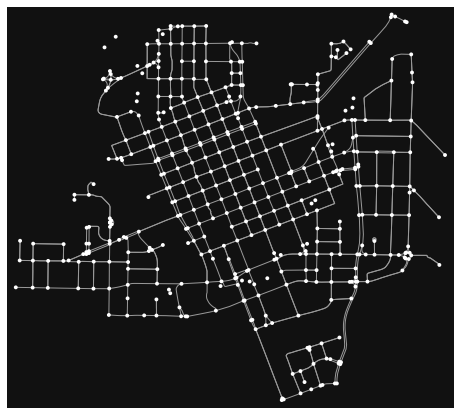

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [31]:
rm_edge_list = []
for u, v, key, data in G.out_edges(data=True, keys=True):
    if data['highway'] == 'motorway' or data['highway'] == 'motorway_link':
        rm_edge_list.append((u, v))

G.remove_edges_from(rm_edge_list)
ox.utils_graph.remove_isolated_nodes(G)
ox.plot_graph(G)

## Indexing using OSM nid

In [32]:
nid_list = []
n_geo_list = []
for nid, data in G.nodes(data = True):
    n_point = shapely.geometry.Point(data['x'], data['y'])
    nid_list.append(nid)
    n_geo_list.append(n_point)

d = {'nid': nid_list, 'geometry': n_geo_list}
node_df = gpd.GeoDataFrame(d, crs = NAD83)
node_df.head()

,nid,geometry
0,97741875,POINT (510436.195 1314046.265)
1,97748245,POINT (511028.254 1315803.932)
2,97743936,POINT (508995.058 1317125.433)
3,308599425,POINT (509282.563 1317123.416)
4,97743961,POINT (508763.206 1317126.771)


## Extract Intersections in Tampa

In [33]:
intersections = ox.consolidate_intersections(G, tolerance= 1, dead_ends=False, rebuild_graph=False)

In [34]:
intersections_df = gpd.GeoDataFrame(intersections, columns=['geometry'], crs=NAD83)
intersections_df.head()

,geometry
0,POINT (506747.110 1311782.853)
1,POINT (506386.154 1311795.855)
2,POINT (506753.623 1312121.746)
3,POINT (506084.292 1312312.140)
4,POINT (506392.997 1312314.385)


### Matching intersections and nodes

In [35]:
def geo_dist_cal(x, y, a, b):
    return np.sqrt(np.square(x - a) + np.square(y - b))

intersections_x = intersections_df.geometry.x.tolist()
intersections_y = intersections_df.geometry.y.tolist()

n_geo_x = node_df.geometry.x.tolist()
n_geo_y = node_df.geometry.y.tolist()

intersections_nid_list = []

for i in range(len(intersections_df)):
    min_dist = np.inf
    min_ind = 0
    for j in range(len(n_geo_x)):
        dist = geo_dist_cal(intersections_x[i], intersections_y[i], n_geo_x[j], n_geo_y[j])
        if dist < min_dist:
            min_dist = dist
            min_ind = j
    intersections_nid_list.append(nid_list[min_ind])

intersections_df['nid'] = intersections_nid_list
intersections_df.head(5)

,geometry,nid
0,POINT (506747.110 1311782.853),97875676
1,POINT (506386.154 1311795.855),97903947
2,POINT (506753.623 1312121.746),97756037
3,POINT (506084.292 1312312.140),97822451
4,POINT (506392.997 1312314.385),97968731


In [36]:
print('Intersection number in Tampa: {}'.format(len(intersections_df)))

Intersection number in Tampa: 427


## Filter Insignificant Intersections

### Intersection in/out degree

In [37]:
intersections_odg = []
intersections_idg = []
intersections_nid = intersections_df.nid.tolist()
for i in range(len(intersections_nid)):
    intersections_odg.append(G.out_degree(intersections_nid[i]))
    intersections_idg.append(G.in_degree(intersections_nid[i]))
intersections_df['odg'] = intersections_odg
intersections_df['idg'] = intersections_idg

In [38]:
intersections_df.head()

,geometry,nid,odg,idg
0,POINT (506747.110 1311782.853),97875676,2,1
1,POINT (506386.154 1311795.855),97903947,1,1
2,POINT (506753.623 1312121.746),97756037,1,1
3,POINT (506084.292 1312312.140),97822451,2,2
4,POINT (506392.997 1312314.385),97968731,2,2


### Intersection Demand Count

In [39]:
import time

df_origin_x = df_origins.geometry.x.tolist()
df_origin_y = df_origins.geometry.y.tolist()
intersections_x = intersections_df.geometry.x.tolist()
intersections_y = intersections_df.geometry.y.tolist()
passenger_number_list = full_dt_data.passengers.to_list()

iOri = np.zeros(len(intersections_x))
start_time = time.time()
for i in range(len(df_origins)):
    min_dist = np.inf
    min_ind = 0
    for j in range(len(intersections_df)):
        dist = geo_dist_cal(df_origin_x[i], df_origin_y[i], intersections_x[j], intersections_y[j])
        if dist < min_dist:
            min_dist = dist
            min_ind = j
    iOri[min_ind] += passenger_number_list[i]
    if (i + 1) % 5000 == 0:
        print('Step: %d, time cost: %d'%(i + 1, time.time() - start_time))
        start_time = time.time()
intersections_df['iOri'] = list(iOri)

del df_origin_x, df_origin_y, intersections_x, intersections_y, passenger_number_list

Step: 5000, time cost: 5
Step: 10000, time cost: 5


In [40]:
intersections_df.head()

,geometry,nid,odg,idg,iOri
0,POINT (506747.110 1311782.853),97875676,2,1,124.0
1,POINT (506386.154 1311795.855),97903947,1,1,0.0
2,POINT (506753.623 1312121.746),97756037,1,1,0.0
3,POINT (506084.292 1312312.140),97822451,2,2,0.0
4,POINT (506392.997 1312314.385),97968731,2,2,8.0


### Intersection vicinity demand count

In [41]:
feet = 1320  # 400 meters = approx 1/4 mile = approx 1320 feet
origins_geo_list = df_origins.geometry.to_list()
passenger_number_list = full_dt_data.passengers.to_list()
vicinityOri = []  # 
for i in range(len(intersections_df)):
    stop = intersections_df.geometry.values[i]
    zone = stop.buffer(feet)
    count = 0
    for j in range(len(df_origins)):
        if origins_geo_list[j].intersects(zone):
            count += passenger_number_list[j]
    vicinityOri.append(count)

intersections_df['vOri'] = vicinityOri
del origins_geo_list, vicinityOri

In [42]:
intersections_df.head()

,geometry,nid,odg,idg,iOri,vOri
0,POINT (506747.110 1311782.853),97875676,2,1,124.0,899
1,POINT (506386.154 1311795.855),97903947,1,1,0.0,895
2,POINT (506753.623 1312121.746),97756037,1,1,0.0,899
3,POINT (506084.292 1312312.140),97822451,2,2,0.0,1349
4,POINT (506392.997 1312314.385),97968731,2,2,8.0,1714


In [43]:
vicinity_demand_count = intersections_df.vOri.to_list()

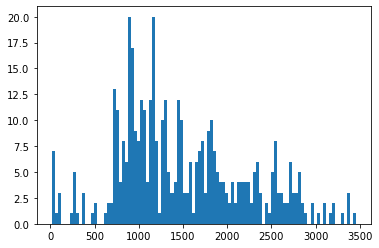

In [44]:
import matplotlib.pyplot as plt

plt.hist(vicinity_demand_count, bins=100)
plt.show()

### Signal control

In [45]:
intersections_df_x_list = intersections_df.geometry.x.to_list()
intersections_df_y_list = intersections_df.geometry.y.to_list()
intersections_df_nid = intersections_df.nid.to_list()
intersections_xy_dict = {}
for i in range(len(intersections_df)):
    intersections_xy_dict[intersections_df_nid[i]] = {}
    intersections_xy_dict[intersections_df_nid[i]]['x'] = intersections_df_x_list[i]
    intersections_xy_dict[intersections_df_nid[i]]['y'] = intersections_df_y_list[i]

id_list = []
for nid, data in G.nodes(data = True):
    try:
        sig = 1 if data['highway'] == 'traffic_signals' else 0
    except:
        sig = 0
    ext = 0
    if sig:
        id_list.append(nid)
print(len(id_list))

136


In [46]:
del intersections_df_x_list, intersections_df_y_list, intersections_df_nid

In [47]:
intersections_df[intersections_df['nid'] == 97835510]

,geometry,nid,odg,idg,iOri,vOri
331,POINT (510606.819 1314526.454),97835510,3,3,0.0,774


## Traffic signal control bundles

In [48]:
traffic_signal_bundles= [[97929648, 2140060419], [259645343, 97772729], [259645520, 97815615], [259645486, 97928970], [259645354, 97952959], [320166155, 1870060138, 940139415], [259645337, 97840861], [1870060187, 1870060182], [1870060133, 1870060195], [1870060232, 1870060119], [1870060109, 1870060165], [1870060202, 1870060169], [320166965, 1870060124], [1604297413, 97928998], [279342809, 97871031], [279342808, 2140060692, 259336727, 2140060725], [279342568, 97850661]]
print(len(traffic_signal_bundles))

17


In [49]:
signal_bundle_dict = dict()
for i in range(len(traffic_signal_bundles)):
    bundle = traffic_signal_bundles[i]
    for j in range(len(bundle)):
        rest_bundle = copy.deepcopy(bundle)
        rest_bundle.remove(bundle[j])
        signal_bundle_dict[bundle[j]] = rest_bundle

In [50]:
print(signal_bundle_dict[259336727])

[279342808, 2140060692, 2140060725]


### Filter intersections by degree and demand

In [51]:
intersections_df_cst = intersections_df.loc[(intersections_df['vOri'] >= 500) & (intersections_df['idg'] > 0) & (intersections_df['odg'] > 0)]
print(len(intersections_df_cst))

377


In [52]:
not_in_list = []
intersections_cst_nid = intersections_df_cst.nid.to_list()
for ele in id_list:
    if ele not in intersections_cst_nid:
        not_in_list.append(ele)
not_in_df = intersections_df[intersections_df.nid.isin(not_in_list)]

intersections_df = intersections_df_cst.append(not_in_df)
print(len(intersections_df))

379


In [53]:
traffic_signals_df = intersections_df[intersections_df['nid'].isin(id_list)]
traffic_signals_list = traffic_signals_df.nid.to_list()
print(len(traffic_signals_df))

136


In [54]:
intersections_nid_list = intersections_df.nid.to_list()
signal_control_list = [nid in id_list for nid in intersections_nid_list]
intersections_df['signal'] = signal_control_list

In [55]:
intersections_df.head()

,geometry,nid,odg,idg,iOri,vOri,signal
0,POINT (506747.110 1311782.853),97875676,2,1,124.0,899,True
1,POINT (506386.154 1311795.855),97903947,1,1,0.0,895,True
2,POINT (506753.623 1312121.746),97756037,1,1,0.0,899,False
3,POINT (506084.292 1312312.140),97822451,2,2,0.0,1349,False
4,POINT (506392.997 1312314.385),97968731,2,2,8.0,1714,True


### Identify bus stop service range

In [56]:
import copy

intersections_geo_list = intersections_df.geometry.to_list()
df_origins_geo = df_origins.geometry.to_list()
intersections_demand_cover_list = []
for i in range(len(intersections_df)):
    demand_list = []
    for t in range(len(df_origins)):
        if  df_origins_geo[t].intersects(intersections_geo_list[i].buffer(1320)):
            demand_list.append(t)
    intersections_demand_cover_list.append(copy.deepcopy(demand_list))

cover_list_dict = {}
intersections_nid_list = intersections_df.nid.to_list()
for i in range(len(intersections_df)):
    cover_list_dict[intersections_nid_list[i]] = copy.deepcopy(intersections_demand_cover_list[i])
    
del intersections_geo_list, df_origins_geo, intersections_demand_cover_list, intersections_nid_list


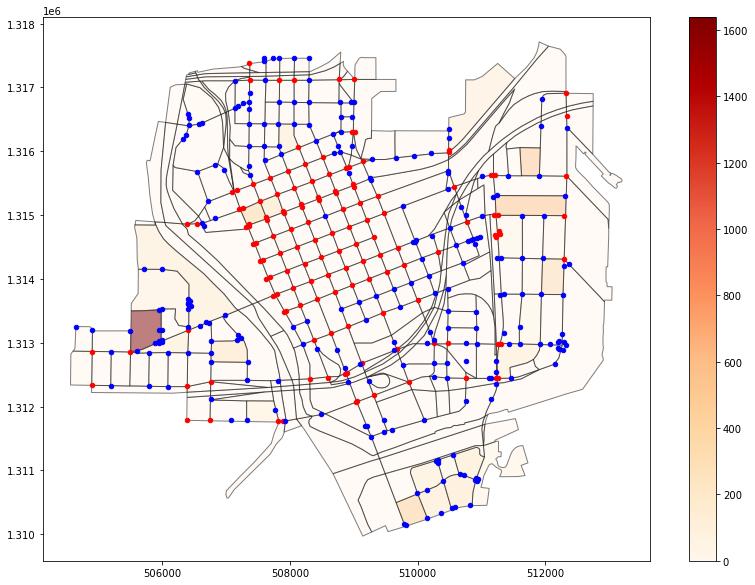

In [57]:
# color = 'green', markersize=20
fig, ax = plt.subplots(figsize=(14,10))
ax.set_aspect('equal')
# AoA_geo = AoA_geo.to_crs(NAD83)
# AoA_geo.plot(ax=ax, color='white', edgecolor='b')
df_tampa_blocks.plot(ax=ax, column='population', cmap='OrRd', edgecolor='black', alpha=0.5, legend = True)
# intersections_df.loc[[97787275, 97781978, 97895171, 97850670, 623853710, 97940380, 97815614]].plot(ax=ax, color = 'red', markersize=20)
intersections_df[intersections_df['signal'] == True].plot(ax=ax, color = 'red', markersize=20)
intersections_df[intersections_df['signal'] == False].plot(ax=ax, color = 'blue', markersize=20)
# intersections_df.iloc[33:34].plot(ax=ax, color = 'red', markersize=20)
fig.show()

In [58]:
# exception_list = [7266120790, 7118196849, 7111223496, 7266120792, 1288042411, 301445298, 97772741, 259636111, 97772729, 97815615, 97928970, 97952959, 940139415, 1870060138, 97840861, 97754267, 5937914322, 1869062606, 97815048, 97815049, 259644903, 601722551, 259645226, 601722547, 601722539, 601722579, 601722578, 601722622, 6507422923, 97796549, 1509217962, 97796547, 7477932893, 1914330259, 1890914263, 97893800, 97851586, 1870060187, 1870060133, ]

In [59]:
intersections_df = intersections_df.reset_index(drop=True)
intersections_df.head()

,geometry,nid,odg,idg,iOri,vOri,signal
0,POINT (506747.110 1311782.853),97875676,2,1,124.0,899,True
1,POINT (506386.154 1311795.855),97903947,1,1,0.0,895,True
2,POINT (506753.623 1312121.746),97756037,1,1,0.0,899,False
3,POINT (506084.292 1312312.140),97822451,2,2,0.0,1349,False
4,POINT (506392.997 1312314.385),97968731,2,2,8.0,1714,True


# Matching origin/destinations to intersections

In [60]:
import time
import numpy as np

def geo_dist_cal(x, y, a, b):
    return np.sqrt(np.square(x - a) + np.square(y - b))

origins_x = df_origins.geometry.x.tolist()
origins_y = df_origins.geometry.y.tolist()
destinations_x = df_destinations.geometry.x.tolist()
destinations_y = df_destinations.geometry.y.tolist()
intersections_x = intersections_df.geometry.x.tolist()
intersections_y = intersections_df.geometry.y.tolist()

origins_node_list = []
destinations_node_list = []
start_time = time.time()
for i in range(len(origins_x)):
    min_dist_o = np.inf
    min_ind_o = 0
    min_dist_d = np.inf
    min_ind_d = 0
    for j in range(len(intersections_df)):
        dist_o = geo_dist_cal(origins_x[i], origins_y[i], intersections_x[j], intersections_y[j])
        dist_d = geo_dist_cal(destinations_x[i], destinations_y[i], intersections_x[j], intersections_y[j])
        if dist_o < min_dist_o:
            min_dist_o = dist_o
            min_ind_o = j
        if dist_d < min_dist_d:
            min_dist_d = dist_d
            min_ind_d = j
    if (i + 1) % 5000 == 0:
        print('Step: %d, time cost: %d'%(i + 1, time.time() - start_time))
        start_time = time.time()
    origins_node_list.append(node_df.nid[min_ind_o])
    destinations_node_list.append(node_df.nid[min_ind_d])
    
del origins_x, origins_y, destinations_x, destinations_y, intersections_x, intersections_y


Step: 5000, time cost: 9
Step: 10000, time cost: 9


In [61]:
full_dt_data['origin_nid'] = origins_node_list
df_origins['nid'] = origins_node_list
full_dt_data['destination_nid'] = destinations_node_list
df_destinations['nid'] = destinations_node_list
full_dt_data.head()


,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,passengers,combo_id,vehicle_type,vehicle_max_pax,date_time,start_time_sec,road_time,origin_nid,destination_nid
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,-82.4526,1,NaN,Ford Transit [ADA],6.0,2019-11-01 07:00:00,25200,4,97752686,1295194249
2,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,-82.4556,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,3,97927106,97815628
5,369709,2856b920792cca226721cce6470f2f6111816fae,60ccbf5aadc3c796ded05d5a7a69e14f93858a16,2019-11-01,12,07:12,07:20,27.9563,-82.4602,27.9453,-82.4581,1,8c6991ff8fd9d96d22393b1cda58788a3467178c,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,8,97876156,97787269
1,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,-82.4629,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,8,97951081,97775176
3,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,-82.4544,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,3,259310138,97840886


# Remove Outliers & Estimate Walking Time

## Create Pedestrian network

In [62]:
G_ped = G.copy()

for u, v, key, data in G_ped.out_edges(data=True, keys=True):
    if data['oneway'] == True:
        G_ped.add_edge(v, u, **data)

for u, v, key, data in G_ped.out_edges(data=True, keys=True):
    attrs = {(u, v, key): {"speed_kph": 5}}
    nx.set_edge_attributes(G_ped, attrs)
ox.speed.add_edge_travel_times(G_ped, precision=2)


In [63]:
import networkx as nx
import utils

stt = time.time()
walk_time = []
pos = []

intersection_time_loss = 15
time_dict_ped, length_dict_ped = utils.create_dict(G_ped)

origins_node_list = df_origins.nid.to_list()
destinations_node_list = df_destinations.nid.to_list()

otl_count = 0

for i in range(len(origins_node_list)):
    source = origins_node_list[i]
    target = destinations_node_list[i]
    try:
        walk_t, walk_dist, walk_paths = utils.multi_source_dijkstra(G_ped, [source], targets = [target], time_dict = time_dict_ped, length_dict = length_dict_ped)
        walk_t, walk_dist, walk_path = walk_t[target], walk_dist[target], walk_paths[target]
        walk_t += intersection_time_loss * len(utils.list_intersection(walk_path, traffic_signals_list, signal_bundle_dict))
        walk_time.append(walk_t)
        pos.append(i)
    except:
        otl_count+=1
    if (i + 1) % 5000 == 0:
        print('Step: %d, time cost: %d'%(i + 1, time.time() - stt))
        stt = time.time()
pos = np.array(pos)
print('Outliers count: ', otl_count)

Step: 5000, time cost: 2
Step: 10000, time cost: 2
Outliers count:  277


In [64]:
full_dt_data = full_dt_data.iloc[pos]
df_origins = df_origins.iloc[pos]
df_destinations = df_destinations.iloc[pos]


In [65]:
full_dt_data['walk_time'] = walk_time


In [66]:
full_dt_data = full_dt_data.reset_index(drop=True)
full_dt_data.head()


,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,...,passengers,combo_id,vehicle_type,vehicle_max_pax,date_time,start_time_sec,road_time,origin_nid,destination_nid,walk_time
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,...,1,NaN,Ford Transit [ADA],6.0,2019-11-01 07:00:00,25200,4,97752686,1295194249,1052.58
1,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,...,1,c040eea05ad281c67908276e27b182c1c0ff0acd,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,3,97927106,97815628,535.44
2,369709,2856b920792cca226721cce6470f2f6111816fae,60ccbf5aadc3c796ded05d5a7a69e14f93858a16,2019-11-01,12,07:12,07:20,27.9563,-82.4602,27.9453,...,1,8c6991ff8fd9d96d22393b1cda58788a3467178c,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,8,97876156,97787269,1338.51
3,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,...,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,8,97951081,97775176,1344.94
4,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,...,1,NaN,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,3,259310138,97840886,1376.89


In [67]:
df_origins = df_origins.reset_index(drop=True)
df_origins.head()


,geometry,nid
0,POINT (505942.920 1313248.683),97752686
1,POINT (510140.739 1313414.714),97927106
2,POINT (507604.002 1317096.217),97876156
3,POINT (511403.743 1314464.406),97951081
4,POINT (507649.141 1311933.383),259310138


In [68]:
df_destinations = df_destinations.reset_index(drop=True)
df_destinations.head()


,geometry,nid
0,POINT (510046.843 1314214.910),1295194249
1,POINT (509077.618 1314036.726),97815628
2,POINT (508266.949 1313094.480),97787269
3,POINT (506737.330 1318408.336),97775176
4,POINT (509455.986 1311599.417),97840886


## Create Vehicle Traffic Network

In [69]:
G_routing = G.copy()
for u, v, key, data in G_routing.out_edges(data=True, keys=True):
    if isinstance(data['highway'], list):
        hw = data['highway'][-1]
    else:
        hw = data['highway']
    if hw == 'trunk':
        attrs = {(u, v, key): {"speed_kph": 45}}
        nx.set_edge_attributes(G_routing, attrs)
    elif hw == 'primary':
        attrs = {(u, v, key): {"speed_kph": 40}}
        nx.set_edge_attributes(G_routing, attrs)
    elif hw == 'secondary':
        attrs = {(u, v, key): {"speed_kph": 35}}
        nx.set_edge_attributes(G_routing, attrs)
    elif hw == 'tertiary':
        attrs = {(u, v, key): {"speed_kph": 30}}
        nx.set_edge_attributes(G_routing, attrs)
    elif hw == 'unclassified':
        attrs = {(u, v, key): {"speed_kph": 25}}
        nx.set_edge_attributes(G_routing, attrs)
    elif hw == 'residential':
        attrs = {(u, v, key): {"speed_kph": 25}}
        nx.set_edge_attributes(G_routing, attrs)
    else:
        attrs = {(u, v, key): {"speed_kph": 25}}
        nx.set_edge_attributes(G_routing, attrs)

ox.speed.add_edge_travel_times(G_routing, precision=2)


In [70]:
drive_distance_list = []
time_dict_eva, length_dict_eva = utils.create_dict(G_routing)

origins_node_list = full_dt_data.origin_nid.to_list()
destinations_node_list = full_dt_data.destination_nid.to_list()

for i in range(len(full_dt_data)):
    source = origins_node_list[i]
    target = destinations_node_list[i]
    try:
        time_, dist_, paths_ = utils.multi_source_dijkstra(G_routing, [source], targets = [target], time_dict = time_dict_eva, length_dict = length_dict_eva)
        time_, dist_, path_ = time_[target], dist_[target], paths_[target]
    except:
        time_, dist_, paths_ = utils.multi_source_dijkstra(G_ped, [source], targets = [target], time_dict = time_dict_ped, length_dict = length_dict_ped)
        time_, dist_, path_ = time_[target], dist_[target], paths_[target]
    drive_distance_list.append(dist_)

full_dt_data['drive_distance'] = drive_distance_list

### Histogram of Downtowner Travel Distance

1163.4262019377868


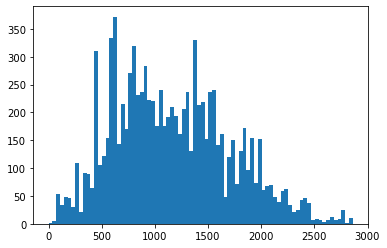

In [71]:
travel_dist = []
origins_node_list = df_origins.nid.to_list()
destinations_node_list = df_destinations.nid.to_list()
for i in range(len(origins_node_list)):
    trip_dist = nx.algorithms.dijkstra_path_length(G_ped, source = origins_node_list[i], target = destinations_node_list[i], weight = 'length')
    travel_dist.append(trip_dist)
print(np.average(travel_dist))
plt.hist(travel_dist, bins = 80)
plt.show()

# Identify top ODs

In [72]:
AoA_geo = AoA_geo.to_crs(NAD83)

In [73]:
minx, miny, maxx, maxy = AoA_geo[0].bounds
delta = 1320 # foot
xsnum = int((maxx - minx) / delta) + 2
ysnum = int((maxy - miny) / delta) + 2
cell_geometry_list = []
for i in range(xsnum):
    for j in range(ysnum):
        x_start = i * delta + (minx - delta / 2)
        y_start = j * delta + (miny - delta / 2)
        x_end = x_start + delta
        y_end = y_start + delta
        cell_geometry_list.append(shapely.geometry.Polygon([
            (x_start, y_start),
            (x_end, y_start),
            (x_end, y_end),
            (x_start, y_end)]))
grid_df = gpd.GeoDataFrame(cell_geometry_list, columns=['geometry'], crs=NAD83)
grid_df = grid_df[grid_df.geometry.intersects(AoA_geo[0])]
grid_index = np.arange(len(grid_df))
grid_df['id'] = grid_index
grid_df.set_index("id", inplace=True)
grid_df.head()

,geometry
id,
0,"POLYGON ((503896.378 1311950.375, 505216.378 1..."
1,"POLYGON ((505216.378 1310630.375, 506536.378 1..."
2,"POLYGON ((505216.378 1311950.375, 506536.378 1..."
3,"POLYGON ((505216.378 1313270.375, 506536.378 1..."
4,"POLYGON ((505216.378 1314590.375, 506536.378 1..."


<AxesSubplot:>

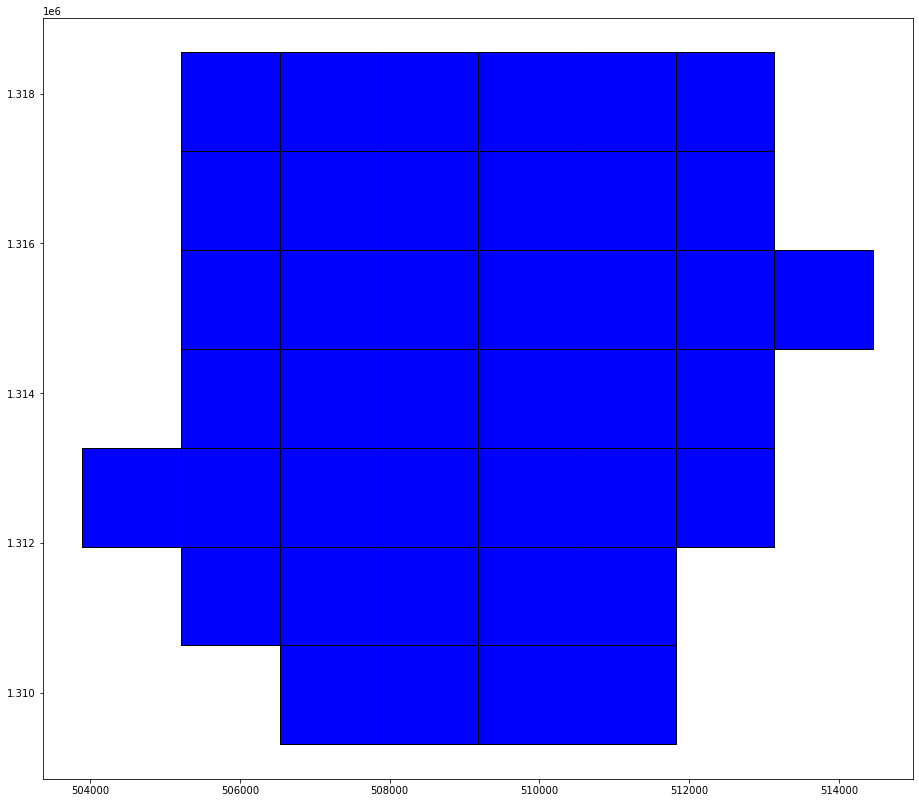

In [74]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')
AoA_geo = AoA_geo.to_crs(NAD83)
# AoA_geo.plot(ax=ax, color='white', edgecolor='b')
# df_tampa_blocks.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
grid_df.plot(ax=ax, color='blue', edgecolor = 'black')

In [75]:
OD_mat = np.zeros((len(grid_df), len(grid_df)))
origin_geo_list = df_origins.geometry.tolist()
destination_geo_list = df_destinations.geometry.tolist()
grid_df_geometry_list = grid_df.geometry.to_list()
passenger_number_list = full_dt_data.passengers.to_list()
OD_cell_ind = []
for i in range(len(origin_geo_list)):
    o_ind = np.nan
    d_ind = np.nan
    for j in range(len(grid_df)):
        if origin_geo_list[i].intersects(grid_df_geometry_list[j]):
            o_ind = j
            if d_ind is not np.nan:
                break
        if destination_geo_list[i].intersects(grid_df_geometry_list[j]):
            d_ind = j
            if o_ind is not np.nan:
                break
    OD_mat[o_ind][d_ind] += passenger_number_list[i]
    OD_cell_ind.append([o_ind, d_ind])

### Locate ODs with the largest travel volume

In [76]:
grid_df.head(5)

,geometry
id,
0,"POLYGON ((503896.378 1311950.375, 505216.378 1..."
1,"POLYGON ((505216.378 1310630.375, 506536.378 1..."
2,"POLYGON ((505216.378 1311950.375, 506536.378 1..."
3,"POLYGON ((505216.378 1313270.375, 506536.378 1..."
4,"POLYGON ((505216.378 1314590.375, 506536.378 1..."


In [77]:
from shapely.geometry import LineString, Point

def geo_dist_cal(x, y, a, b):
    return np.sqrt(np.square(x - a) + np.square(y - b))

primal_num = 20
primal_od_list = []
grid_df_centroid_list = grid_df.geometry.centroid.to_list()

for i in range(OD_mat.shape[0]):
    for j in range(OD_mat.shape[1]):
        o_centroid = grid_df_centroid_list[i]
        d_centroid = grid_df_centroid_list[j]
        if geo_dist_cal(o_centroid.x, o_centroid.y, d_centroid.x, d_centroid.y) > 0:
            if len(primal_od_list) < primal_num:
                primal_od_list.append((OD_mat[i, j], [o_centroid, d_centroid], [i, j]))
                primal_od_list = sorted(primal_od_list, key=lambda x: x[0], reverse = True)
            elif OD_mat[i, j] > primal_od_list[-1][0]:
                primal_od_list.pop()
                primal_od_list.append((OD_mat[i, j], [o_centroid, d_centroid], [i, j]))
                primal_od_list = sorted(primal_od_list, key=lambda x: x[0], reverse = True)

top_od_geo_list = []
top_od_count_list = []
for i in range(primal_num):
    line_string = shapely.geometry.LineString([primal_od_list[i][1][0], primal_od_list[i][1][1]])
    top_od_geo_list.append(line_string)
    top_od_count_list.append(primal_od_list[i][0])
top_od_df = gpd.GeoDataFrame(top_od_geo_list, columns=['geometry'], crs=NAD83)
top_od_df['counts'] = top_od_count_list

In [78]:
primal_od_list[:5]

[(227.0,
  [32, 17]),
 (196.0,
  [12, 17]),
 (179.0,
  [17, 12]),
 (175.0,
  [2, 17]),
 (167.0,
  [12, 11])]

[196.0, 179.0, 175.0, 167.0, 165.0, 160.0, 149.0, 121.0, 121.0, 116.0, 98.0, 95.0, 89.0, 88.0, 86.0, 84.0, 81.0, 81.0, 81.0, 79.0, 77.0, 77.0, 76.0, 74.0, 73.0, 70.0, 70.0, 69.0, 67.0, 66.0, 65.0, 65.0, 64.0, 63.0, 63.0, 59.0, 57.0, 57.0, 57.0, 56.0, 56.0, 55.0, 55.0, 54.0, 52.0, 52.0, 52.0, 51.0, 51.0, 50.0]


Text(0.5, 0, 'Number of OD pairs')

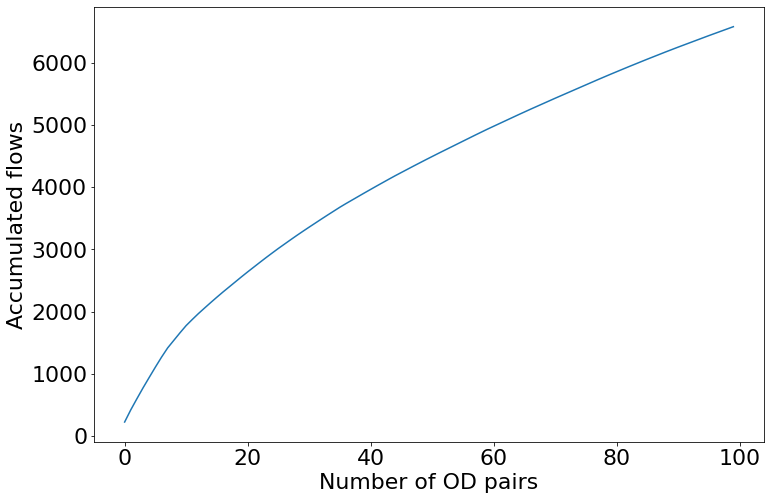

In [79]:
from shapely.geometry import LineString, Point

primal_num = 20
od_volume_list = []
grid_df_centroid_list = grid_df.geometry.centroid.to_list()

for i in range(OD_mat.shape[0]):
    for j in range(OD_mat.shape[1]):
        o_centroid = grid_df_centroid_list[i]
        d_centroid = grid_df_centroid_list[j]
        od_volume_list.append(OD_mat[i, j])
od_volume_list = sorted(od_volume_list, reverse = True)

accumulate_volume = []
count = 0
for i in range(len(od_volume_list)):
    count += od_volume_list[i]
    accumulate_volume.append(count)

deviation_list = []
for i in range(1, len(od_volume_list)):
    d = accumulate_volume[i] - accumulate_volume[i - 1]
    deviation_list.append(d)
print(deviation_list[:50])
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(accumulate_volume[:100])
plt.ylabel('Accumulated flows')
plt.xlabel('Number of OD pairs')

In [80]:
od_in_TOP_OD = (np.ones(len(df_origins)) * 9999).astype(int)
for i in range(len(df_origins)):
    for pod_ind in range(len(primal_od_list)):
        if OD_cell_ind[i][0] == primal_od_list[pod_ind][2][0] and OD_cell_ind[i][1] == primal_od_list[pod_ind][2][1]:
            od_in_TOP_OD[i] = pod_ind
            

In [81]:
grid_df.head()


,geometry
id,
0,"POLYGON ((503896.378 1311950.375, 505216.378 1..."
1,"POLYGON ((505216.378 1310630.375, 506536.378 1..."
2,"POLYGON ((505216.378 1311950.375, 506536.378 1..."
3,"POLYGON ((505216.378 1313270.375, 506536.378 1..."
4,"POLYGON ((505216.378 1314590.375, 506536.378 1..."


In [82]:
top_od_df.head()


,geometry,counts
0,"LINESTRING (511156.378 1315250.375, 508516.378...",227.0
1,"LINESTRING (507196.378 1316570.375, 508516.378...",196.0
2,"LINESTRING (508516.378 1313930.375, 507196.378...",179.0
3,"LINESTRING (505876.378 1312610.375, 508516.378...",175.0
4,"LINESTRING (507196.378 1316570.375, 507196.378...",167.0


In [83]:
import momepy

G_to_ods = momepy.gdf_to_nx(top_od_df, approach="primal", directed = True)
positions = {n: [n[0], n[1]] for n in list(G_to_ods.nodes)}

count_max = np.max(top_od_count_list)
count_min = np.min(top_od_count_list)

width_list = [((count - count_min) / (count_max - count_min)) * 20 + 1 for count in top_od_count_list]


In [84]:
type(G_to_ods)


networkx.classes.multidigraph.MultiDiGraph

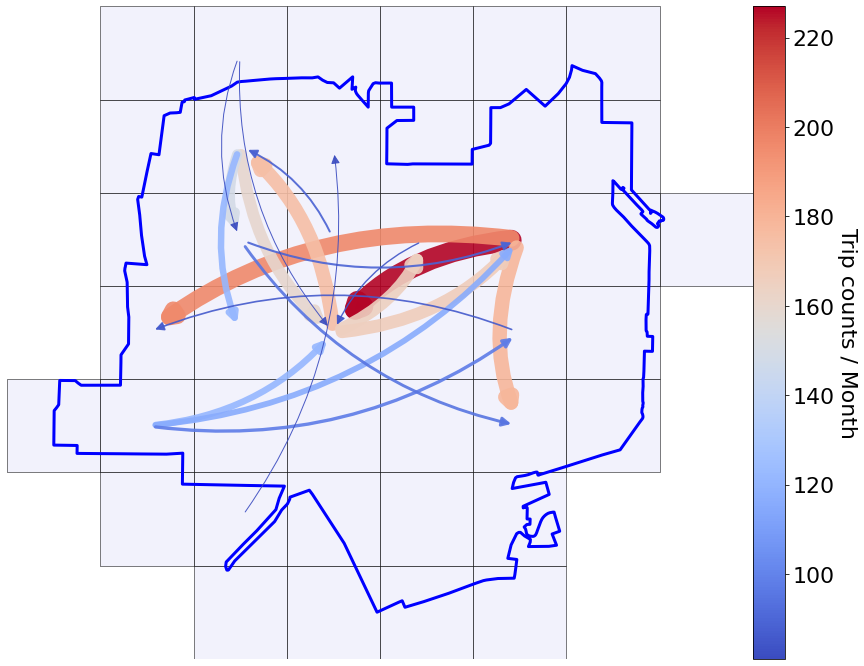

In [85]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo = AoA_geo.to_crs(NAD83)
# AoA_geo.plot(ax=ax, color='white', edgecolor='b')
grid_df.plot(ax=ax, color='lavender', edgecolor = 'black', alpha = 0.5)
AoA_geo.plot(ax=ax, color='none', edgecolor='b', linewidth = 3)
# grid_df.loc[:10].plot(ax=ax, color='red', edgecolor = 'black', alpha = 1.0)
# top_od_df.plot(ax=ax, color='red', alpha = 1, linewidth = 3)
# df_tampa_blocks.plot(ax=ax, color='white', edgecolor='black', alpha=.5)

cmap = plt.cm.coolwarm

nx.drawing.nx_pylab.draw_networkx_edges(G_to_ods, positions, width = width_list, edge_color = top_od_count_list, edge_cmap = cmap, edge_vmin=count_min, edge_vmax=count_max, arrows = True, arrowsize = 18, connectionstyle = 'arc3,rad=0.2', alpha = 0.9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = count_min, vmax=count_max))
sm._A = []
fig.colorbar(sm, pad = 0).set_label('Trip counts / Month', rotation=270, labelpad = 23)
# plt.show()
# ax.arrow( 131400, 504000, 0.0, -200, fc="k", ec="k",head_width=0.05, head_length=0.1 )
# df_tampa_blocks.plot(ax=ax, column='population', cmap='OrRd', edgecolor='black', alpha=0.5, legend = True)
plt.axis('off')
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig("top_od_pure.pdf", bbox_inches = 'tight',
#     pad_inches = 0)
fig.show()

In [86]:
top_od_volume_list = [x[0] for x in primal_od_list]
print(top_od_volume_list)


[227.0, 196.0, 179.0, 175.0, 167.0, 165.0, 160.0, 149.0, 121.0, 121.0, 116.0, 98.0, 95.0, 89.0, 88.0, 86.0, 84.0, 81.0, 81.0, 81.0]


## Identify Regular User

In [87]:
user_dict = {}
dtn_rider = full_dt_data.rider_id.to_list()
for i in range(len(dtn_rider)):
    if dtn_rider[i] in user_dict.keys():
        user_dict[dtn_rider[i]] += 1
    else:
        user_dict[dtn_rider[i]] = 1
print(len(user_dict))
sorted_user_dict = {key: value for key, value in sorted(user_dict.items(), key=lambda item: item[1], reverse=True)}
count = 0
for key, value in sorted_user_dict.items():
    count += 1
    if count > 10:
        break
    print(key, ' : ', value)
    

2075
9976845cc643c026eefce33b6d6782294485e8b5  :  98
c2a48296bb79bb34353c2518e4af4ff522a3a1d6  :  73
6b40e66552c6429e40d65add807a582f2d4442ef  :  59
a5959aafa9d45ac2df91f40f70f104a44eb98889  :  55
f25ae03935e7a40626773366180deedd28052b4f  :  53
7cedaf7336597f0bc84b2361c023a609adcbda21  :  52
fa52526703d91f4e1dcf1e7227736376a66812ba  :  50
f133d05337a6beb651ab7256d8e324af3644f3e3  :  49
eb2e1f6a559e4f9db06960c1479e485a244f3130  :  44
c7fcfc309f6285417882dcc8684d305bfd97ae72  :  41


In [88]:
regular_user_dict = {key: value for key, value in user_dict.items() if value >= 15}
regular_user_list = list(regular_user_dict.keys())
regular_user_number = len(regular_user_list)
print(regular_user_number)


172


In [89]:
regular_user_index = [user in regular_user_list for user in dtn_rider]


In [90]:
full_dt_data['regular_user'] = regular_user_index


In [91]:
full_dt_data.head()


,Unnamed: 0,ride_id,rider_id,date,wait_time_minutes,pickup_time,dropoff_time,pickup_lat,pickup_lon,dropoff_lat,...,vehicle_type,vehicle_max_pax,date_time,start_time_sec,road_time,origin_nid,destination_nid,walk_time,drive_distance,regular_user
0,369704,2b2a5bd877a46e9a32574b5a399c3a11e21909e7,17cd1681c84ff8b0f2d2829fc0a8c47496a2e84e,2019-11-01,10,07:10,07:14,27.9457,-82.4653,27.9484,...,Ford Transit [ADA],6.0,2019-11-01 07:00:00,25200,4,97752686,1295194249,1052.58,1986.837,True
1,369706,6e370efaaf21d4672a4e4be0ec74bece5aa7fd44,fa98f0fdae3d27a0cfad96720c74598b3321c616,2019-11-01,7,07:07,07:10,27.9462,-82.4523,27.9479,...,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,3,97927106,97815628,535.44,653.171,True
2,369709,2856b920792cca226721cce6470f2f6111816fae,60ccbf5aadc3c796ded05d5a7a69e14f93858a16,2019-11-01,12,07:12,07:20,27.9563,-82.4602,27.9453,...,Chevrolet Bolt,4.0,2019-11-01 07:00:00,25200,8,97876156,97787269,1338.51,1723.509,True
3,369705,02a725ab14c77507e45e125a533d2aeffa045c41,3e63328aaadd153aec8d14377b4a304b73236cc4,2019-11-01,1,07:02,07:10,27.9491,-82.4484,27.9599,...,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,8,97951081,97775176,1344.94,1781.925,False
4,369707,c0d8143030128356810ab3c2f5e67b6be755eecb,cfab35daba0e20d5d92e51d9d44c438da8bec6d2,2019-11-01,7,07:08,07:11,27.9421,-82.4600,27.9412,...,Chevrolet Bolt,4.0,2019-11-01 07:01:00,25260,3,259310138,97840886,1376.89,1901.668,False


# Create Available Bus Stops

In [92]:
stops_df = copy.deepcopy(intersections_df)
len(stops_df)


379

In [93]:
stops_df.set_index("nid", inplace=True)
stops_df.head()


,geometry,odg,idg,iOri,vOri,signal
nid,,,,,,
97875676,POINT (506747.110 1311782.853),2,1,124.0,899,True
97903947,POINT (506386.154 1311795.855),1,1,0.0,895,True
97756037,POINT (506753.623 1312121.746),1,1,0.0,899,False
97822451,POINT (506084.292 1312312.140),2,2,0.0,1349,False
97968731,POINT (506392.997 1312314.385),2,2,8.0,1714,True


In [94]:
stops_df.head()


,geometry,odg,idg,iOri,vOri,signal
nid,,,,,,
97875676,POINT (506747.110 1311782.853),2,1,124.0,899,True
97903947,POINT (506386.154 1311795.855),1,1,0.0,895,True
97756037,POINT (506753.623 1312121.746),1,1,0.0,899,False
97822451,POINT (506084.292 1312312.140),2,2,0.0,1349,False
97968731,POINT (506392.997 1312314.385),2,2,8.0,1714,True


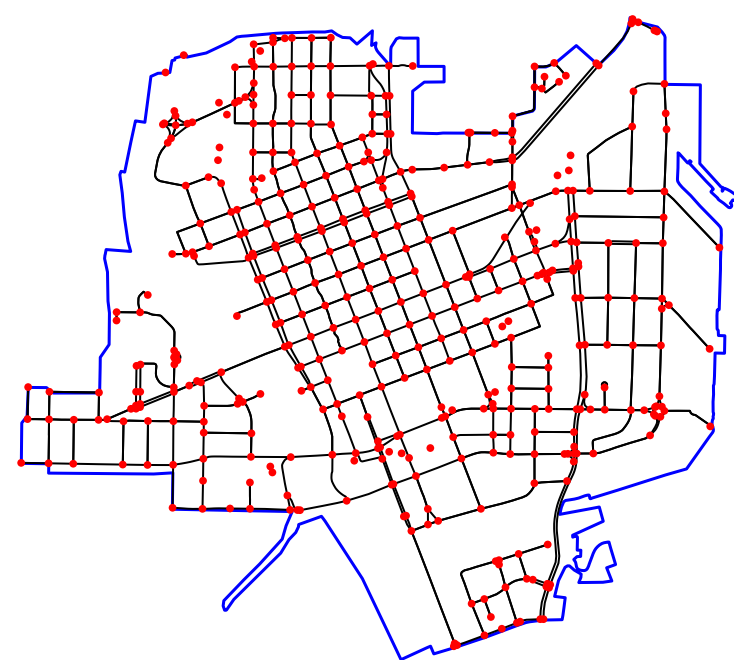

In [95]:
AoA_geo = AoA_geo.to_crs(NAD83)

fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b', linewidth = 3)
# df_tampa_blocks.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
ox.plot_graph(G, ax=ax, node_color = 'red', edge_color = 'black', edge_linewidth = 2, node_size = 60, bgcolor = 'white', show = False, close=False)
# stops_df.geometry.plot(ax=ax, color='red', markersize=20)
plt.axis('off')
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig("road_network.pdf", bbox_inches = 'tight',
#     pad_inches = 0, facecolor=fig.get_facecolor())
# fig.show()

### Demo Route

In [96]:
importlib.reload(utils)

route_list = [[97871012, 1870060195, 97921078, 97796644, 97964892]]
fleet_size = [1]
time_dict, length_dict = utils.create_dict(G_routing)

utils.graph_creation(G_ped, G_routing, route_list, fleet_size, traffic_signals_list, time_dict, length_dict, intersections_xy_dict, signal_bundle_dict, intersection_time_loss, stop_time_loss = 15, tolerance = 300, no_repeat = True, complex_mode = False, zero_wait = False, cutoff = None)

(<networkx.classes.multidigraph.MultiDiGraph at 0x7fc27fcad730>,
 array([0.]),
 array([250.27]),
 array([0.]),
 [351.461, 269.584, 176.36, 211.379],
 array([1008.784]),
 [1.0240507073276366])

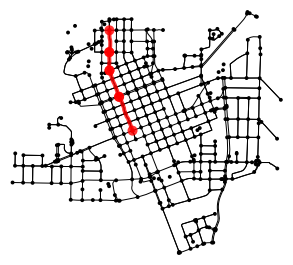

In [97]:
utils.plot_routes([route_list[0]], G_routing, time_dict, length_dict, route_linewidth = 30, orig_dest_size=100, route_alpha = 0.8, i = None, no_repeat = False, complex_mode = False, cutoff = 10, figsize=(5, 5), save = False)#, filepath= './bus_routes_1_0.pdf')

### Determine Neighbours of Each Stop

In [98]:
stops_df_nid = stops_df.index.to_list()
bus_neighbours = {}
for i in range(len(stops_df)):
    neighbour_list = []
    for j in range(len(stops_df)):
        if len(list(nx.all_simple_paths(G_routing, source = stops_df_nid[i], target = stops_df_nid[j], cutoff = 5))) != 0:
            neighbour_list.append(stops_df_nid[j])
    bus_neighbours[stops_df_nid[i]] = neighbour_list

## Estimate per vehicle budget based on Downtowner budget

In [99]:
Downtowner_funds = np.array([515314, 104228, 13755, 16156, 52542, 5081, 62468, 6846, 120831])
np.sum(Downtowner_funds)

897221

In [100]:
Downtowner_funds = np.array([515314, 104228, 13755, 16156, 52542, 5081, 62468, 6846, 120831])
Downtowner_funds_per_vehicle = Downtowner_funds / 9
Bus_funds_per_vehicle = Downtowner_funds_per_vehicle * np.array([2, 2, 1, 2, 2, 1, 1, 1, 1])
cost_per_bus = np.sum(Bus_funds_per_vehicle)
print('Cost to maintain a bus per year: %d'%(cost_per_bus))

Cost to maintain a bus per year: 176162


In [101]:
Downtowner_funds_per_vehicle


array([57257.11111111, 11580.88888889,  1528.33333333,  1795.11111111,
        5838.        ,   564.55555556,  6940.88888889,   760.66666667,
       13425.66666667])

### Feasable Fleet Sets

In [102]:
total_funds = 898221
for i in range(int(total_funds / cost_per_bus)):
    bus_funds = cost_per_bus * i
    taxi_funds = total_funds - bus_funds
    taxi_number = int(taxi_funds / np.sum(Downtowner_funds_per_vehicle))
    print('Bus number = %d, taxi number = %d'%(i, taxi_number))
    

Bus number = 0, taxi number = 9
Bus number = 1, taxi number = 7
Bus number = 2, taxi number = 5
Bus number = 3, taxi number = 3
Bus number = 4, taxi number = 1


# Transit Network Evaluation

### Demo

In [103]:
importlib.reload(utils)

stt = time.time()

stop_time_loss = 15
no_repeat = False
complex_mode = False

bus_lines = [[97925459, 259645343, 97772744, 7118196849]]
bus_fleet_size = [2]
taxi_fleet_size = 0
value_coefficients = [1., 1., 1., 0.5, 0.2, 0.2, 0.2, 0.2]
global_eva = True
OD_related_input_dict = {
    'od_in_TOP_OD': od_in_TOP_OD,
    'OD_cell_ind': OD_cell_ind,
    'primal_od_list': primal_od_list
}

unit_bus_cost = cost_per_bus / 365 * 30
unit_taxi_cost = np.sum(Downtowner_funds_per_vehicle) / 365 * 30

utils.evaluation_agent_based(taxi_fleet_size, full_dt_data, bus_lines, bus_fleet_size, G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, value_coefficients = value_coefficients, global_eva = global_eva, start_hour = 7, end_hour = 22, print_ = True)
print('='*30)
print('Simulation time cost:', time.time() - stt)



Average transit time saving ratio: 0.1483982846609498
Transit system GHG emission: 1153781.3083970763
Private car GHG emission: 978084.8557736202
Transit GHG emission saving ratio: -0.17963313876738057
Average taxi_travel_time: nan

Waiting Time
total_bus_wait_time: 201277.6300000006
average_bus_wait_time: 88.86429580573977
total_taxi_wait_time: 0.0
average_taxi_wait_time: nan
total_transit_wait_time: 201277.6300000006
average_transit_wait_time: 88.86429580573977

Benefit-cost Ratio
bus_benefit: 2138.135734459997
bus_benefit_cost_ratio: 0.0738352639779123
taxi_benefit: 0.0
taxi_benefit_cost_ratio: nan
transit_benefit: 2138.135734459997
transit_benefit_cost_ratio: 0.0738352639779123
Benefit per bus rider: 0.9439892867373055
Benefit per transit rider: 0.9439892867373055

Bus cost per ridership: 12.785073633916962
Transit per ridership cost: 12.785073633916962
Transit per rider cost - benefit: 11.841084347179656

travel_by_walk_ratio: 0.8211183067445901
travel_by_bus_ratio: 0.17888169325

## Load initial route sets

In [104]:
class Line_Pool():
    def __init__(self, route_list=None):
        self.pool = []
        if route_list is not None:
            for i in range(len(route_list)):
                if isinstance(route_list[i], tuple):
                    self.update(route_list[i][2])
                else:
                    self.append(route_list[i])
        
    def update(self, route_lines):
#         print(route_lines)
        for i in range(len(route_lines)):
            line = route_lines[i]
            if (not line in self.pool) and (len(line) >= 3):
                self.pool.append(line)
                
    def append(self, line):
        if not line in self.pool:
            self.pool.append(line)
        
    def pool_size(self):
        return len(self.pool)
    
    def random_choose(self, num):
        random_indices = np.random.choice(np.arange(self.pool_size()), num, replace = False)
        selected_lines = []
        for i in range(len(random_indices)):
            selected_lines.append(self.pool[random_indices[i]])
            
        if num == 1:
            return copy.deepcopy(selected_lines[0])
        else:
            return copy.deepcopy(selected_lines)



In [105]:
# Generated randomly

initial_line_pool = [[301446819, 97929653, 97876148, 97876619],
 [97797861, 97871017, 97775156, 97964888, 97840866, 97822449],
 [97871012, 97928972, 1870060195, 97921078, 97796644, 97964892],
 [301446819, 97929653, 942206727, 97835510, 97876619],
 [301446819, 975495316, 97775163, 97797861],
 [97927142, 97840599, 97775154, 97775163, 97797861],
 [97797861, 97775156, 301446819],
 [301446819, 97929653, 97876619],
 [301446819, 97871012, 97964888, 97946542, 97796644, 97964892],
 [97929653,  942206727,  97835510,  97876619,  97797861,  97748224,  1993753421,  97775156,  97929653],
 [97925455,  97871013,  97942623,  97840870,  97796648,  97775185,  97964892,  97753737,  1870060182,  975495316,  97925455],
 [301446819, 97871012, 97964888, 97925463],
 [97925455,  97871013,  97942623,  97942627,  97796646,  97964892,  97753737,  1870060182,  975495316,  97925455],
 [97815049, 975495316, 301446819],
 [97775156, 97928978, 97797861],
 [97797861, 97871017, 97775156, 97921079, 97787275, 97775153, 1194972212],
 [97876619, 97775154, 97754832, 97840599],
 [97876619,  97850650,  97797861,  97871017,  97787279,  97873120,  97775163,  97880467,  97754832,  97840599],
 [97815049, 97754832, 97775154, 1870060133, 97775163],
 [301446819, 975495316, 97775163, 97927140, 97797861],
 [301446819, 975495315, 97964888, 97946542, 97796644, 97964892],
 [301446819,  97952959,  1870060133,  97946542,  97775174, 1870060109,  97970376,  97927140,  1604297413],
 [97763679, 1295194181, 97923650, 97925463, 1870060182, 975495316, 97925455, 97775154, 6955301678, 97927140, 320166965, 1870060232, 97921079, 97851341, 97763679], 
 [97763679, 97851341, 97921079, 1870060232, 320166965, 97927140, 6955301678, 97775154, 97925455, 975495316, 1870060182, 97925463, 97923650, 1295194181, 97763679],
 [1870060187, 975495316, 97925455, 97775154, 6955301678, 97927140, 320166965, 1870060232, 1870060187],
 [1870060187, 1870060232, 320166965, 97927140, 6955301678, 97775154, 97925455, 975495316, 1870060187],
 [97876619, 97787269, 623851709, 7266623122, 97909732, 5580280696, 97781978, 97787275, 97873120, 97815615, 940139415, 1870060119, 1870060124, 97927140, 97928985, 97873423, 97815614, 97876619],
 [97876619, 97815614, 97873423, 97928985, 97927140, 1870060124, 1870060119, 940139415, 97815615, 97873120, 97787275, 97781978, 5580280696, 97909732, 7266623122, 623851709, 97787269, 97876619],
 [301446819, 97772744, 97772729, 97873120, 97787275, 97781978, 5580280697],
 [97873423, 97815614, 97871033, 282526504, 97850650, 7266623123]]

In [106]:
line_pool = Line_Pool(initial_line_pool)

In [107]:
def initial_routes_generator(line_pool, route_pool_size, taxi_fleet_size, full_dt_data, max_bus_fleet_size, G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, global_eva = global_eva, value_coefficients = value_coefficients, start_hour = 7, end_hour = 22, fix = True):
    init_route_list = []
    for R_ in range(route_pool_size):
        init_route_list.append([])
        line_number = np.random.choice(range(1, max_bus_fleet_size + 1), 1)[0]
        line_indices = np.random.choice(range(line_pool.pool_size()), line_number, replace = False)
        for line_ in range(line_number):
            init_route_list[R_].append(line_pool.pool[line_indices[line_]])

    for i in range(len(init_route_list)):
        route = copy.deepcopy(init_route_list[i])#model.route_list[i][1])
        score, fleet_size = utils.evaluate_bus_fleet_assign_agent_based(taxi_fleet_size, full_dt_data, route, max_bus_fleet_size, G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, value_coefficients = value_coefficients, global_eva = global_eva, start_hour = 7, end_hour = 22)
        init_route_list[i] = copy.deepcopy((score, fleet_size, route))

    init_route_list = sorted(init_route_list, key=lambda x: x[0], reverse = True)
    return init_route_list

## Initialize Initial Gene Pool

In [108]:
# import utils
importlib.reload(utils)

max_bus_fleet_size = 1
taxi_fleet_size = 0
route_pool_size = 20
fix = True
init_route_list = initial_routes_generator(line_pool, route_pool_size, taxi_fleet_size, full_dt_data, max_bus_fleet_size, G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, global_eva = global_eva, value_coefficients = value_coefficients, start_hour = 7, end_hour = 22, fix = fix)


In [109]:
import time
import copy
import utils
importlib.reload(utils)
        
class RouteFinder:
    def __init__(self, stops_df, bus_neighbours, max_bus_fleet_size, taxi_fleet_size, full_dt_data, G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, global_eva = global_eva, value_coefficients = value_coefficients, start_hour = 7, end_hour = 22, route_list_init = None):
        '''
        evaluation(child_a, self.G_ped, self.G_routing, self.origins_node_list, self.destinations_node_list, self.walk_time, self.scaler, self.od_in_TOP_OD, self.intersections_df, self.OD_cell_ind, self.primal_od_list, no_repeat = self.no_repeat, complex_mode = self.complex_mode, cutoff = self.cutoff, stop_time_loss = self.stop_time_loss, print_res = False)
        INPUT: bus_stops = list of shapely point objects
        '''
        self.stops_df = stops_df
        self.max_bus_fleet_size = max_bus_fleet_size
        self.G_ped = G_ped
        self.G_routing = G_routing
        self.bus_stops_nid = stops_df.index.tolist()
        self.bus_stops_geo = stops_df.geometry.tolist()
        self.route_list = None

        self.taxi_fleet_size = taxi_fleet_size
        self.full_dt_data = full_dt_data
        self.origins_node_list = self.full_dt_data.origin_nid.to_list()
        self.destinations_node_list = self.full_dt_data.destination_nid.to_list()
        self.intersections_xy_dict = intersections_xy_dict

        self.stops_x = stops_df.geometry.x.tolist()
        self.stops_y = stops_df.geometry.y.tolist()
        self.stops_nid = stops_df.index.tolist()
        self.no_repeat = no_repeat
        self.complex_mode = complex_mode
        self.stop_time_loss = stop_time_loss
        self.intersection_time_loss = intersection_time_loss
        
        self.unit_bus_cost = unit_bus_cost
        self.unit_taxi_cost = unit_taxi_cost
        self.traffic_signals_list = traffic_signals_list
        self.signal_bundle_dict = signal_bundle_dict
        
        self.OD_related_input_dict = OD_related_input_dict
        self.global_eva = global_eva
        self.start_hour = start_hour
        self.end_hour = end_hour
        
        self.value_coefficients = value_coefficients
        
        if route_list_init is not None:
            self.route_list = copy.deepcopy(route_list_init)
            
        if line_pool is None:
            self.line_pool = Line_Pool()
        else:
            self.line_pool = line_pool
        
        self.bus_neighbours = bus_neighbours


    def evolve(self, epochs):
        start_time = time.time()
        stops_set = set(self.bus_stops_nid)
        score_list = copy.deepcopy([self.route_list[i][0] for i in range(len(self.route_list))])
        for i in range(epochs):
            parents_ind = np.random.choice(np.arange(len(self.route_list)), 2)
            parent_a = copy.deepcopy(self.route_list[parents_ind[0]][2])
            parent_b = copy.deepcopy(self.route_list[parents_ind[1]][2])
            child_a = copy.deepcopy(parent_a)
            child_b = copy.deepcopy(parent_b)
            # Inter string cross-over
            swap_num = np.random.choice(np.arange(len(parent_a)), 1)[0]
            for s in range(swap_num):
                swap_a_ind = np.random.choice(np.arange(len(parent_a)), 1)[0]
                swap_b_ind = np.random.choice(np.arange(len(parent_b)), 1)[0]
                
                child_a[swap_a_ind] = copy.deepcopy(parent_b[swap_b_ind])
                child_b[swap_b_ind] = copy.deepcopy(parent_a[swap_a_ind])
            
            for child_ind in range(2):
                if child_ind == 0:
                    child_lines = copy.deepcopy(child_a)
                else:
                    child_lines = copy.deepcopy(child_b)
                if len(child_lines) >= 2:
                    for try_time in range(5):
                        ab_choice = np.random.choice(np.arange(len(child_lines)), 2)

                        line_a = child_lines[ab_choice[0]]
                        line_b = child_lines[ab_choice[1]]

                        rand_a = sorted(list(np.random.randint(0,high=len(line_a), size=2)))
                        rand_b = sorted(list(np.random.randint(0,high=len(line_b), size=2)))

                        # Slice the Routes
                        a_start = [j for j in line_a if line_a.index(j) < rand_a[0]]
                        a_end = [j for j in line_a if line_a.index(j) > rand_a[1]]

                        b_start = [j for j in line_b if line_b.index(j) < rand_b[0]]
                        b_end = [j for j in line_b if line_b.index(j) > rand_b[1]]

                        #Shuffle the Bag
                        a_bag = [j for j in line_a if j not in a_start and j not in a_end]
                        b_bag = [j for j in line_b if j not in b_start and j not in b_end]
                        mixed_bag = a_bag + b_bag
                        random.shuffle(mixed_bag)

                        # Assign Nodes to Routes
                        while mixed_bag:
                            choose_route = np.random.choice(['a','b'])
                            pop_pt = mixed_bag.pop()
                            if choose_route == 'a':
                                a_start.append(pop_pt)
                            else:
                                b_start.append(pop_pt)

                        revised_a = a_start + a_end
                        revised_b = b_start + b_end
                        if (len(revised_a) > 3) and (len(revised_b) > 3):
                            break
                            
                    if len(revised_a) <= 4:
                        revised_a = self.line_pool.random_choose(1)
                    if len(revised_b) <= 4:
                        revised_b = self.line_pool.random_choose(1)
                    
                    if child_ind == 0:
                        child_a[ab_choice[0]] = copy.deepcopy(revised_a)
                        child_a[ab_choice[1]] = copy.deepcopy(revised_b)
                    else:
                        child_b[ab_choice[0]] = copy.deepcopy(revised_a)
                        child_b[ab_choice[1]] = copy.deepcopy(revised_b)
            
            pop_l = []
            for l in range(len(child_a)):
                rest_stops = list(stops_set - set(child_a[l]))
                pop_s = []
                for s in range(len(child_a[l])):
                    if np.random.rand() > 0.97:
                        optional_list = list(set(rest_stops).intersection(self.bus_neighbours[child_a[l][s]]))
                        if len(optional_list) != 0:
                            child_a[l][s] = np.random.choice(optional_list, 1)[0] # Random mutate to neighbor stops
                    if np.random.rand() > 0.997:
                        pop_s.append(s) # Randomly delete stops
                for p in range(len(pop_s)):
                    if len(child_a[l]) > 4:   # Prevent line from deprecating to zero
                        child_a[l].pop(pop_s[p] - p)
                
            for l in range(len(child_a)):
                rest_stops = list(stops_set - set(child_a[l]))
                for s in range(len(child_a[l])):
                    if np.random.rand() > 0.96:
                        try:
                            neighbour_set = self.bus_neighbours[child_a[l][s]].intersection(self.bus_neighbours[child_a[l][s-1]])
                        except:
                            neighbour_set = self.bus_neighbours[child_a[l][s]]
                        optional_list = list(set(rest_stops).intersection(neighbour_set))
                        if len(optional_list) != 0:
                            child_a[l].insert(s ,np.random.choice(optional_list, 1)[0]) # Randomly insert stops
            child_a = utils.trim_duplicate(child_a, score_included = False)
            
            pop_l_a = []
            for l in range(len(child_a)):
                if np.random.rand() > 0.98:
                    child_a[l] = self.line_pool.random_choose(1) # Random mutate line from line pool
                if np.random.rand() > 0.99:
                    pop_l_a.append(l)
            for p in range(len(pop_l_a)):
                if len(child_a) > 1:
                    child_a.pop(pop_l_a[p] - p)  # Random remove line from child route setting
            
                
            for l in range(len(child_a)):
                if (np.random.rand() > 0.95) and (len(child_a) < self.max_bus_fleet_size):
                    random_line = self.line_pool.random_choose(1)
                    if random_line not in child_a:
                        child_a.insert(l, random_line) # Random insert line from line pool
                                  
            for l in range(len(child_a)):
                if child_a[l][0] != child_a[l][-1] and np.random.rand() > 0.998:
                    child_a[l].append(child_a[l][0])  # Random create loop
            
            
            for l in range(len(child_b)):
                rest_stops = list(stops_set - set(child_b[l]))
                pop_s = []
                for s in range(len(child_b[l])):
                    if np.random.rand() > 0.97:
                        optional_list = list(set(rest_stops).intersection(self.bus_neighbours[child_b[l][s]]))
                        if len(optional_list) != 0:
                            child_b[l][s] = np.random.choice(optional_list, 1)[0]
                    if np.random.rand() > 0.997:
                        pop_s.append(s)
                for p in range(len(pop_s)):
                    if len(child_b[l]) > 4: 
                        child_b[l].pop(pop_s[p] - p)
                
            for l in range(len(child_b)):
                rest_stops = list(stops_set - set(child_b[l]))
                for s in range(len(child_b[l])):
                    if np.random.rand() > 0.96:
                        try:
                            neighbour_set = self.bus_neighbours[child_b[l][s]].intersection(self.bus_neighbours[child_b[l][s-1]])
                        except:
                            neighbour_set = self.bus_neighbours[child_b[l][s]]
                        optional_list = list(set(rest_stops).intersection(neighbour_set))
                        if len(optional_list) != 0:
                            child_b[l].insert(s ,np.random.choice(optional_list, 1)[0])
            child_b = utils.trim_duplicate(child_b, score_included = False)

            pop_l_b = []
            for l in range(len(child_b)):
                if np.random.rand() > 0.98:
                    child_b[l] = self.line_pool.random_choose(1) # Random mutate line from line pool
                if np.random.rand() > 0.99:
                    pop_l_b.append(l)
            for p in range(len(pop_l_b)):
                if len(child_b) > 1:
                    child_b.pop(pop_l_b[p] - p)  # Random remove line from child route setting
            
                
            for l in range(len(child_b)):
                if (np.random.rand() > 0.95) and (len(child_b) < self.max_bus_fleet_size):
                    random_line = self.line_pool.random_choose(1)
                    if random_line not in child_b:
                        child_b.insert(l, random_line) # Random insert line from line pool
            
    
            for l in range(len(child_b)):
                if child_b[l][0] != child_b[l][-1] and np.random.rand() > 0.998:
                    child_b[l].append(child_b[l][0])
            
            
            if len(child_a) != 0:
                if utils.bus_validity_check(child_a, self.G_routing, self.no_repeat, self.complex_mode) == False:
                    child_a_score = -np.inf
                else:
                    child_a_score, child_a_fleet_size = utils.evaluate_bus_fleet_assign_agent_based(self.taxi_fleet_size, self.full_dt_data, child_a, self.max_bus_fleet_size, self.G_ped, self.G_routing, self.traffic_signals_list, self.signal_bundle_dict, self.intersections_xy_dict, self.stop_time_loss, self.no_repeat, self.complex_mode, self.unit_bus_cost, self.unit_taxi_cost, self.intersection_time_loss, OD_related_input_dict = self.OD_related_input_dict, global_eva = self.global_eva, value_coefficients = self.value_coefficients, start_hour = self.start_hour, end_hour = self.end_hour)
            else:
                child_a_score = -np.inf
            if len(child_b) != 0:
                if utils.bus_validity_check(child_b, self.G_routing, self.no_repeat, self.complex_mode) == False:
                    child_b_score = -np.inf
                else:
                    child_b_score, child_b_fleet_size = utils.evaluate_bus_fleet_assign_agent_based(self.taxi_fleet_size, self.full_dt_data, child_b, self.max_bus_fleet_size, self.G_ped, self.G_routing, self.traffic_signals_list, self.signal_bundle_dict, self.intersections_xy_dict, self.stop_time_loss, self.no_repeat, self.complex_mode, self.unit_bus_cost, self.unit_taxi_cost, self.intersection_time_loss, OD_related_input_dict = self.OD_related_input_dict, global_eva = self.global_eva, value_coefficients = self.value_coefficients, start_hour = self.start_hour, end_hour = self.end_hour)
            else:
                child_b_score = -np.inf

            if child_a_score > self.route_list[-1][0] and child_a_score not in score_list:
                # print('--bingo--')
                # print(child_a_score)
                # print(child_a_fleet_size)
                # print(child_a)
                self.line_pool.update(child_a)
                a = self.route_list.pop()
                self.route_list.append((child_a_score, child_a_fleet_size, child_a))
                self.route_list = sorted(self.route_list, key=lambda x: x[0], reverse = True)
                score_list = copy.deepcopy([self.route_list[i][0] for i in range(len(self.route_list))])
            if child_b_score > self.route_list[-1][0] and child_b_score not in score_list:
                # print('--bingo--')
                # print(child_b_score)
                # print(child_b_fleet_size)
                # print(child_b)
                self.line_pool.update(child_b)
                a = self.route_list.pop()
                self.route_list.append((child_b_score, child_b_fleet_size, child_b))
                self.route_list = sorted(self.route_list, key=lambda x: x[0], reverse = True)
                score_list = copy.deepcopy([self.route_list[i][0] for i in range(len(self.route_list))])
            if (i + 1) % 100 == 0:
                print('Iter: %d, time cost = %d'%(i + 1, time.time() - start_time))
                start_time = time.time()
            
    def geo_dist_cal(self, x, y, a, b):
        return np.sqrt(np.square(x - a) + np.square(y - b))

In [110]:
model = RouteFinder(stops_df, bus_neighbours, max_bus_fleet_size, taxi_fleet_size, full_dt_data, G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, global_eva = global_eva, value_coefficients = value_coefficients, start_hour = 7, end_hour = 22, route_list_init = init_route_list)


In [111]:
importlib.reload(utils)

<module 'utils' from '/home/jinming/Projects/Tampa_TNP/MITO/utils.py'>

In [112]:
importlib.reload(utils)

model.evolve(500)

Iter: 100, time cost = 2060
Iter: 200, time cost = 2138
Iter: 300, time cost = 2112
Iter: 400, time cost = 2049
Iter: 500, time cost = 2106


In [113]:
# (Score, Fleet Sizes, Routes)
model.route_list[0]

(1.4808912604734616,
 [1],
 [[1288042411, 97772729, 97775163, 97927140, 97928985]])

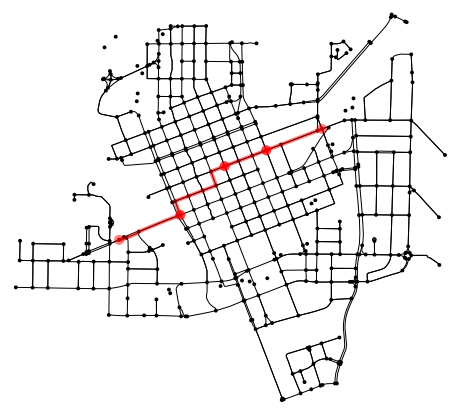

In [114]:
time_dict, length_dict = utils.create_dict(G_routing)
utils.plot_routes(model.route_list[0][2], G_routing, time_dict, length_dict, i = None, no_repeat = False, complex_mode = False, cutoff = 10)


In [115]:
utils.evaluation_agent_based(taxi_fleet_size, full_dt_data, model.route_list[0][2], model.route_list[0][1], G_ped, G_routing, traffic_signals_list, signal_bundle_dict, intersections_xy_dict, stop_time_loss, no_repeat, complex_mode, unit_bus_cost, unit_taxi_cost, intersection_time_loss, OD_related_input_dict = OD_related_input_dict, global_eva = global_eva, start_hour = 7, end_hour = 22, print_ = True)



Average transit time saving ratio: 0.13893847186404915
Transit system GHG emission: 509384.86028496095
Private car GHG emission: 871099.1715268769
Transit GHG emission saving ratio: 0.4152389567859388
Average taxi_travel_time: nan

Waiting Time
total_bus_wait_time: 358465.09000000043
average_bus_wait_time: 180.49601711983908
total_taxi_wait_time: 0.0
average_taxi_wait_time: nan
total_transit_wait_time: 358465.09000000043
average_transit_wait_time: 180.49601711983908

Benefit-cost Ratio
bus_benefit: 1816.598540679998
bus_benefit_cost_ratio: 0.12546353407902167
taxi_benefit: 0.0
taxi_benefit_cost_ratio: nan
transit_benefit: 1816.598540679998
transit_benefit_cost_ratio: 0.12546353407902167
Benefit per bus rider: 0.9147021856394754
Benefit per transit rider: 0.9147021856394754

Bus cost per ridership: 7.2905820193408655
Transit per ridership cost: 7.2905820193408655
Transit per rider cost - benefit: 6.37587983370139

travel_by_walk_ratio: 0.843152740483336
travel_by_bus_ratio: 0.156847259

(1.4808912604734616,
 (7.2905820193408655,
  0.12546353407902167,
  1816.598540679998,
  0.15684725951666403,
  180.49601711983908,
  0.13893847186404915,
  509384.86028496095,
  0.4152389567859388))